### Read data

Dziękuję za dokumentację wstępną. Cieszę się żę uwzględnili Państwo moje uwagi odnośnie dodatkowych algorytmów optymalizacji.
Z drobnych uwag to polecałbym skorzystać z gotowej biblioteki do algorytmów genetycznych np. PyGAD
W dokumentacji brakuje mi informacji na temat podziału zbioru danych na treningowy (na którym otpymalizować powinni Państwo knn-a, walidacyjnym na którym obliczane będą metryki i testowy - który wykorzystany będzie do wyznaczenia końcowej jakości rozwiązania)

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from sklearn.datasets import load_svmlight_file
import pandas as pd
from time import time

def get_data():
    # Assuming 'farm-ads-vect' is in SVMlight format
    X, y = load_svmlight_file('data/farm-ads-vect')

    # Convert sparse matrix to DataFrame
    df_vectors = pd.DataFrame.sparse.from_spmatrix(X)

    return df_vectors, y

In [3]:
df, labels = get_data()

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54867,54868,54869,54870,54871,54872,54873,54874,54875,54876
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.shape

(4143, 54877)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, X_test, y_test):
    """
    Evaluate a logistic regression model on the test data.

    Parameters:
    - model: trained logistic regression model
    - X_test: DataFrame, feature vectors for testing
    - y_test: Series, true labels for testing

    Returns:
    - accuracy: float, accuracy of the model on the test set
    - report: str, classification report (includes precision, recall, f1-score, and support)
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, f1


def train_knn(X_train, y_train, n_neighbors=5):
    """
    Train a k-nearest neighbors (KNN) model on the training data.

    Parameters:
    - X_train: DataFrame, feature vectors for training
    - y_train: Series, labels for training
    - n_neighbors: int, number of neighbors to consider (default is 5)

    Returns:
    - model: trained KNN model
    """
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

In [7]:
from typing import List


def evaluate_attribute_set(attribute_names: List[str], df, labels):
    df_temp = df[attribute_names]

    X_train, X_val, y_train, y_val = train_test_split(df_temp, labels, test_size=0.2, random_state=42)

    # Train the logistic regression model
    model = train_knn(X_train, y_train)

    # Evaluate the model
    accuracy, f1 = evaluate_model(model, X_val, y_val)

    return accuracy, f1

In [8]:
def sequential_forward_selection(df, labels, max_features=None):
    """
    Perform Sequential Forward Selection (SFS) for feature selection.

    Parameters:
    - X_train: DataFrame, feature vectors for training
    - y_train: Series, labels for training
    - X_test: DataFrame, feature vectors for testing
    - y_test: Series, true labels for testing
    - max_features: int, maximum number of features to select (default is None)

    Returns:
    - best_features: list, selected features
    """
    num_features = df.shape[1]
    all_features = list(df.columns)
    selected_features = []
    best_accuracy = 0.0
    best_f1 = 0.0

    df_performance = pd.DataFrame(columns=["selected_features", "num_selected_features", "time", "accuracy_validate"])
    start_time = time()
    while len(selected_features) < num_features and (max_features is None or len(selected_features) < max_features):
        time_start_new_feature = time()
        remaining_features = [feature for feature in all_features if feature not in selected_features]
        current_best_feature = None

        for feature in remaining_features:  # iterate over all remaining feature
            trial_features = selected_features + [feature]
            accuracy, f1 = evaluate_attribute_set(trial_features, df, labels)

            if accuracy > best_accuracy and f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                current_best_feature = feature

        if current_best_feature is not None:
            selected_features.append(current_best_feature)
            print(f"Selected Features: {selected_features}")
            print(f"Accuracy with Selected Features: {best_accuracy:.2f}")

            # Update the condition to ensure it only happens when a feature is added.
            df_performance = pd.concat([df_performance, pd.DataFrame({
                "selected_features": [selected_features.copy()],  # Ensuring this is a list of lists
                "num_selected_features": [len(selected_features)],
                "time_of_feature_selection": [time() - time_start_new_feature],
                "time": [time() - start_time],
                "accuracy_validate": [best_accuracy],
                "f1_validate": [best_f1]
            })])
        else:  # if no better feature than current best, have been found among the remaining features, return the dataset
            return selected_features, best_accuracy, best_f1, df_performance

    return selected_features, best_accuracy, best_f1, df_performance

In [9]:
N_OF_FEATURES_TO_TEST = 1000
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:N_OF_FEATURES_TO_TEST], labels, test_size=0.2, random_state=42)

In [14]:
selected_features, best_accuracy, best_f1, df_performance = sequential_forward_selection(X_train, y_train, max_features=30)
selected_features, best_accuracy

Selected Features: [15]
Accuracy with Selected Features: 0.64
Selected Features: [15, 314]
Accuracy with Selected Features: 0.72
Selected Features: [15, 314, 428]
Accuracy with Selected Features: 0.75
Selected Features: [15, 314, 428, 387]
Accuracy with Selected Features: 0.78
Selected Features: [15, 314, 428, 387, 141]
Accuracy with Selected Features: 0.79
Selected Features: [15, 314, 428, 387, 141, 504]
Accuracy with Selected Features: 0.81
Selected Features: [15, 314, 428, 387, 141, 504, 707]
Accuracy with Selected Features: 0.81
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392]
Accuracy with Selected Features: 0.82
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392, 457]
Accuracy with Selected Features: 0.82
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392, 457, 351]
Accuracy with Selected Features: 0.83
Selected Features: [15, 314, 428, 387, 141, 504, 707, 392, 457, 351, 461]
Accuracy with Selected Features: 0.83
Selected Features: [15, 314, 428, 387, 141,

KeyboardInterrupt: 

In [ ]:
df, labels, max_features = X_train, y_train, 30
num_features = df.shape[1]
all_features = list(df.columns)
selected_features = []
best_accuracy = 0.0
best_f1 = 0.0

df_performance = pd.DataFrame(columns=["selected_features", "num_selected_features", "time", "accuracy_validate"])
start_time = time()
while len(selected_features) < num_features and (max_features is None or len(selected_features) < max_features):
    time_start_new_feature = time()
    remaining_features = [feature for feature in all_features if feature not in selected_features]
    current_best_feature = None

    for feature in remaining_features:  # iterate over all remaining feature
        trial_features = selected_features + [feature]
        accuracy, f1 = evaluate_attribute_set(trial_features, df, labels)

        if accuracy > best_accuracy and f1 > best_f1:
            best_accuracy = accuracy
            best_f1 = f1
            current_best_feature = feature

    if current_best_feature is not None:
        selected_features.append(current_best_feature)
        print(f"Selected Features: {selected_features}")
        print(f"Accuracy with Selected Features: {best_accuracy:.2f}")

        # Update the condition to ensure it only happens when a feature is added.
        df_performance = pd.concat([df_performance, pd.DataFrame({
            "selected_features": [selected_features.copy()],  # Ensuring this is a list of lists
            "num_selected_features": [len(selected_features)],
            "time_of_feature_selection": [time() - time_start_new_feature],
            "time": [time() - start_time],
            "accuracy_validate": [best_accuracy],
            "f1_validate": [best_f1]
        })])

In [ ]:
df_performance.to_csv("sfs_run_30_1000.csv", index=True)

In [ ]:
df_performance

### Test solution

In [87]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a logistic regression model on the test data.

    Parameters:
    - model: trained logistic regression model
    - X_test: DataFrame, feature vectors for testing
    - y_test: Series, true labels for testing

    Returns:
    - accuracy: float, accuracy of the model on the test set
    - report: str, classification report (includes precision, recall, f1-score, and support)
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, f1

def train_knn(X_train, y_train, n_neighbors=5):
    """
    Train a k-nearest neighbors (KNN) model on the training data.

    Parameters:
    - X_train: DataFrame, feature vectors for training
    - y_train: Series, labels for training
    - n_neighbors: int, number of neighbors to consider (default is 5)

    Returns:
    - model: trained KNN model
    """
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

df_test = pd.DataFrame(columns=['accuracy', 'f1', 'num_selected_features'])
for selected_features in df_performance['selected_features']:
    X_train_t = X_train[selected_features]
    # train model
    model = train_knn(X_train_t, y_train)
    accuracy, f1 = evaluate_model(model, X_test[selected_features], y_test)

    df_temp = pd.DataFrame(columns=['accuracy', 'f1', 'num_selected_features'],
        data = [[accuracy, f1, len(selected_features)]])
    df_test = pd.concat([df_test,df_temp])

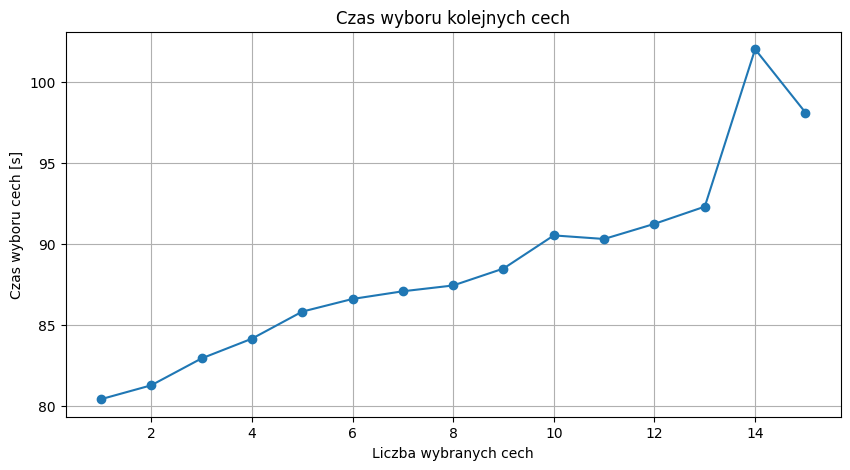

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(df_performance
['num_selected_features'], df_performance
['accuracy_validate'], marker='o')

plt.title('Czas wyboru kolejnych cech')
plt.xlabel('Liczba wybranych cech')
plt.ylabel('Czas wyboru cech [s]')
plt.grid(True)
plt.show()

In [88]:
df_test

,accuracy,f1,num_selected_features
0,0.682750,0.770706,1
0,0.741858,0.801484,2
0,0.762364,0.812915,3
0,0.774427,0.820709,4
0,0.781665,0.824442,5
0,0.781665,0.824442,6
0,0.781665,0.824782,7
0,0.781665,0.824442,8
0,0.785283,0.826848,9
0,0.784077,0.825366,10


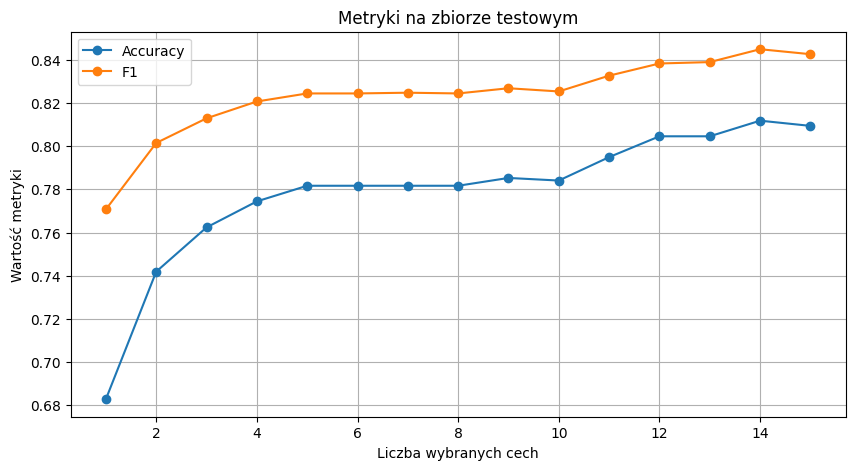

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(df_test
['num_selected_features'], df_test
['accuracy'], marker='o', label='Accuracy')
plt.plot(df_test
['num_selected_features'], df_test
['f1'], marker='o', label='F1')

plt.title('Metryki na zbiorze testowym')
plt.xlabel('Liczba wybranych cech')
plt.ylabel('Wartość metryki')
plt.legend()
plt.grid(True)
plt.show()

## Simulated annealing

In [123]:
import random
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from time import time

def simulated_annealing(df, labels, initial_temp, final_temp, alpha, max_iter):
    """
    Perform Simulated Annealing for feature selection.

    Parameters:
    df : DataFrame
        The dataset containing all potential features.
    labels : Series or array-like
        The target variable for the dataset.
    initial_temp : float
        The initial temperature for the annealing process.
    final_temp : float
        The final temperature at which the annealing process will stop.
    alpha : float
        The cooling rate of the temperature after each iteration.
    max_iter : int
        The maximum number of iterations to perform.

    Returns:
    best_set : list
        The best set of features found.
    best_accuracy : float
        The best accuracy achieved with the best set of features.
    best_f1 : float
        The best F1 score achieved with the best set of features.
    df_benchmark : DataFrame
        A DataFrame recording the benchmark data of each iteration, including feature count, feature set, accuracy, F1 score, and other relevant metrics.
    """
    BENCHMARK_COLS = ["Iteration", "Feature Count", "Feature Set", "Accuracy", "F1", "Acceptance Probability", "Random Number", "Operation", "Improved", "curr_temp"]
    df_benchmark = pd.DataFrame(columns=BENCHMARK_COLS)

    current_temp = initial_temp
    num_features = df.shape[1]
    all_features = list(df.columns)
    current_set = random.sample(all_features, k=random.randint(1, num_features))  # Random initial set

    best_set = current_set.copy()
    best_accuracy, best_f1 = evaluate_attribute_set(best_set, df, labels)

    for iteration in range(max_iter):
        if current_temp <= final_temp:
            break

        new_set, operation = make_random_change(current_set, all_features)
        accuracy, f1 = evaluate_attribute_set(new_set, df, labels)

        decision, random_num, probability = accept_change(best_accuracy, accuracy, current_temp)
        if decision:
            current_set = new_set
            if accuracy > best_accuracy:
                best_set = current_set
                best_accuracy = accuracy
                best_f1 = f1

        current_temp *= alpha  # Cooling step

        # "Iteration", "Feature Count", "Feature Set", "Accuracy", "F1", "Acceptance Probability", "Random Number", "Operation", "Improved"
        iteration_data = pd.DataFrame(columns=BENCHMARK_COLS,
                                      data=[[iteration, len(current_set), current_set, accuracy, f1, probability, random_num, operation, int(decision), current_temp]])

        df_benchmark = pd.concat([df_benchmark, iteration_data])
    return best_set, best_accuracy, best_f1, df_benchmark

def make_random_change(current_set, all_features):
    """
    Make a random change to the current set of features.

    Parameters:
    current_set : list
        The current set of selected features.
    all_features : list
        The list of all possible features.

    Returns:
    current_set : list
        The modified set of features after the random change.
    operation : str
        The type of operation performed ('add', 'remove', or 'swap').
    """
    operation = random.choice(["add", "remove", "swap"])
    if operation == "add":
        # Add a random feature not in the current set
        possible_additions = list(set(all_features) - set(current_set))
        if possible_additions:
            feature_to_add = random.choice(possible_additions)
            current_set.append(feature_to_add)
    elif operation == "remove":
        # Remove a random feature from the current set
        if current_set:
            feature_to_remove = random.choice(current_set)
            current_set.remove(feature_to_remove)
    elif operation == "swap":
        # Swap a feature in the set with one outside it
        if current_set and len(all_features) > len(current_set):
            feature_to_remove = random.choice(current_set)
            current_set.remove(feature_to_remove)
            possible_additions = list(set(all_features) - set(current_set))
            feature_to_add = random.choice(possible_additions)
            current_set.append(feature_to_add)
    return current_set, operation

def accept_change(best_accuracy, new_accuracy, temperature):
    """
    Determine whether to accept the new set of features based on the Simulated Annealing acceptance criterion.

    Parameters:
    best_accuracy : float
        The best accuracy achieved so far.
    new_accuracy : float
        The accuracy achieved with the new set of features.
    temperature : float
        The current temperature in the annealing process.

    Returns:
    decision : bool
        A boolean indicating whether the new set of features is accepted.
    random_num : float
        A random number generated for the probabilistic decision.
    probability : float
        The calculated probability used to determine the acceptance of the new feature set.
    """
    probability = 0
    random_num = 0
    if new_accuracy > best_accuracy:
        decision = True # Always accept if the new solution is better
    else:
        # Calculate the probability of acceptance and accept based on it
        probability = np.exp((new_accuracy - best_accuracy) / temperature)
        random_num = random.random()
        decision = random.random() < probability
    return decision, random_num, probability

In [150]:
N_OF_FEATURES_TO_TEST = 1000
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:N_OF_FEATURES_TO_TEST], labels, test_size=0.2, random_state=42)

In [151]:
# Example usage
MAX_ITER=100

best_set, best_accuracy, best_f1, df_benchmark = simulated_annealing(X_train, y_train,
                                                                     initial_temp=0.5,
                                                                     final_temp=0.01,
                                                                     alpha=0.98,
                                                                     max_iter=MAX_ITER)
best_accuracy, best_f1

(0.8144796380090498, 0.8321964529331514)

In [152]:
df_benchmark

,Iteration,Feature Count,Feature Set,Accuracy,F1,Acceptance Probability,Random Number,Operation,Improved,curr_temp
0,0,273,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.802413,0.821282,0,0,add,1,0.490000
0,1,274,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.800905,0.820163,0.996927,0.239931,add,1,0.480200
0,2,273,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.800905,0.820652,0.996864,0.373143,remove,1,0.470596
0,3,272,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.800905,0.820652,0.9968,0.543774,remove,1,0.461184
0,4,273,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.799397,0.819048,0.99348,0.678567,add,1,0.451960
...,...,...,...,...,...,...,...,...,...,...
0,95,270,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.790347,0.805594,0.719663,0.182947,swap,1,0.071891
0,96,271,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.788839,0.806094,0.700006,0.695875,add,1,0.070453
0,97,272,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.787330,0.804979,0.68021,0.550458,add,0,0.069044
0,98,271,"[594, 677, 361, 393, 119, 959, 255, 869, 982, ...",0.788839,0.806094,0.689787,0.099252,remove,0,0.067663


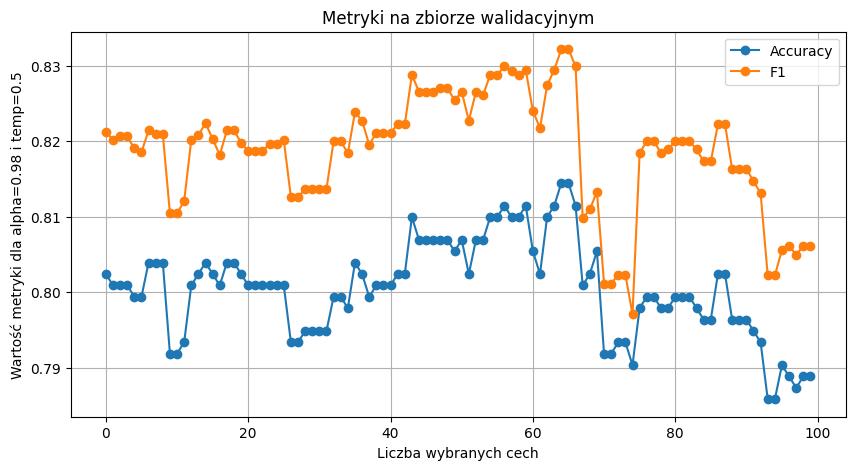

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(df_benchmark['Iteration'], df_benchmark
['Accuracy'], marker='o', label='Accuracy')
plt.plot(df_benchmark['Iteration'], df_benchmark
['F1'], marker='o', label='F1')

plt.title('Metryki na zbiorze walidacyjnym')
plt.xlabel('Liczba wybranych cech')
plt.ylabel('Wartość metryki dla alpha=0.98 i temp=0.5')
plt.legend()
plt.grid(True)
plt.show()

### Second implementation  -  WRONG
based on vector of ones and zeros to record which feature to choose

In [80]:
def simulated_annealing(df, labels, initial_temp, final_temp, alpha, num_features_target):
    num_features = df.shape[1]
    current_vector = np.random.choice([0, 1], size=num_features)
    # Ensure the initial vector has exactly num_features_target features
    current_vector = adjust_vector_to_target(current_vector, num_features_target)
    best_vector = current_vector.copy()

    best_accuracy, best_f1 = evaluate_attribute_set(best_vector, df, labels)

    current_temp = initial_temp
    while current_temp > final_temp:
        new_vector = make_random_change(current_vector.copy(), num_features_target)
        accuracy, f1 = evaluate_attribute_set(new_vector, df, labels)

        if accept_change(best_accuracy, accuracy, current_temp):
            current_vector = new_vector
            if accuracy > best_accuracy:
                best_vector = current_vector
                best_accuracy = accuracy
                best_f1 = f1

        current_temp *= alpha

    return best_vector, best_accuracy, best_f1

def make_random_change(current_vector, num_features_target):
    # Get indices where features are currently selected (1) and not selected (0)
    indices_with_1 = np.where(current_vector == 1)[0]
    indices_with_0 = np.where(current_vector == 0)[0]

    # Check if the number of selected features matches num_features_target
    if len(indices_with_1) > num_features_target:
        # More features selected than desired, randomly remove features
        indices_to_remove = np.random.choice(indices_with_1, size=(len(indices_with_1) - num_features_target), replace=False)
        current_vector[indices_to_remove] = 0
    elif len(indices_with_1) < num_features_target:
        # Fewer features selected than desired, randomly add features
        indices_to_add = np.random.choice(indices_with_0, size=(num_features_target - len(indices_with_1)), replace=False)
        current_vector[indices_to_add] = 1
    else:
        # Exactly num_features_target features are selected, perform a swap
        idx_to_remove = np.random.choice(indices_with_1)
        idx_to_add = np.random.choice(indices_with_0)
        current_vector[idx_to_remove] = 0
        current_vector[idx_to_add] = 1

    return current_vector

def adjust_vector_to_target(vector, num_features_target):
    # Adjust the vector to have exactly num_features_target features
    current_count = np.sum(vector)
    while current_count != num_features_target:
        if current_count < num_features_target:
            idx_to_add = np.random.choice(np.where(vector == 0)[0])
            vector[idx_to_add] = 1
        elif current_count > num_features_target:
            idx_to_remove = np.random.choice(np.where(vector == 1)[0])
            vector[idx_to_remove] = 0
        current_count = np.sum(vector)
    return vector

In [81]:
N_OF_FEATURES_TO_TEST = 100
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :N_OF_FEATURES_TO_TEST], labels, test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, :N_OF_FEATURES_TO_TEST], labels, test_size=0.2,
                                                    random_state=42)

In [83]:
# Example usage
num_features_target = 5  # Set the number of features you want to select
selected_vector, accuracy, f1 = simulated_annealing(df, labels, initial_temp=1000, final_temp=1, alpha=0.95, num_features_target=num_features_target)

KeyboardInterrupt: 

In [ ]:
accuracy